In [ ]:
from keras.layers import Input, Dense, Reshape, Flatten, Conv2DTranspose, Conv2D
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import numpy as np

In [ ]:
#defining input image dimensions
rows=120
cols=160
channels=3
img_shape = (rows,cols,channels)

In [ ]:
#building a generator
def build_generator():
  noise_shape = (100,) #1D latent vector of size 100 - Input to generator
  #building the model
  model=Sequential()
  model.add(Dense(30*40*128,input_shape=noise_shape))
  model.add(Reshape((30,40,128)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Conv2DTranspose(64,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Conv2DTranspose(3,(3,3),strides=(2,2),padding='same',activation='tanh'))

  model.summary()

  noise=Input(shape=noise_shape)
  img=model(noise) #Generated image

  return Model(noise,img)

In [ ]:
#building a discriminator
def build_discriminator():
  model=Sequential()
  model.add(Conv2D(64,kernel_size=(3,3),strides=(2,2),padding='same',input_shape=img_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,kernel_size=(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dense(100))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1,activation='sigmoid'))
  model.summary()

  img=Input(shape=img_shape)
  validity=model(img)

  return Model(img,validity)

In [ ]:
disc_loss=[]
gen_loss=[]

In [ ]:
def train(epochs,batch_size,save_interval):
  #loading dataset
  X_train=pickle.load(open('drive/MyDrive/X_train.pkl','rb'))
  #rescaling the images
  X_train = (X_train.astype(np.float32)-127.5)/127.5

  for epoch in range(epochs+1):
    '''
    train discriminator
    '''
    #select random batch of real images
    id=np.random.randint(0,X_train.shape[0],batch_size)
    imgs=X_train[id]
    #generate batch of fake images
    noise=np.random.normal(0,1,(batch_size,100))
    gen_imgs=generator.predict(noise)
    #discriminator loss
    d_loss_real=discriminator.train_on_batch(imgs,np.ones((batch_size,1)))
    d_loss_fake=discriminator.train_on_batch(gen_imgs,np.zeros((batch_size,1)))
    d_loss=0.5*np.add(d_loss_real,d_loss_fake)
    disc_loss.append(d_loss[0])

    '''
    train generator
    '''
    noise=np.random.normal(0,1,(batch_size,100))
    valid_y=np.array([1]*batch_size)
    #generator loss
    g_loss=combined.train_on_batch(noise,valid_y)
    gen_loss.append(g_loss)

    print(epoch,' ',d_loss[0],' ',g_loss)

    #saving images
    if epoch%save_interval==0:
      save_imgs(epoch)

In [ ]:
def save_imgs(epoch):
  r,c=5,5
  noise=np.random.normal(0,1,(r*c,100))
  gen_imgs=generator.predict(noise)
  #rescale images 0-1
  gen_imgs=0.5*gen_imgs+0.5
  
  fig,axs=plt.subplots(r,c)
  cnt=0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt,:,:,:])
      axs[i,j].axis('off')
      cnt+=1
  fig.savefig("drive/MyDrive/GAN_images_NUS_I/NUS_I_%d.png"%epoch)
  plt.close()
  generator.save('drive/MyDrive/GAN_models_NUS_I/generator_model_test%d.h5'%epoch)

In [ ]:
#choosing the optimizer
optimizer=Adam(0.0002,0.5)

#building the discriminator
discriminator=build_discriminator()
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

#building the generator
generator=build_generator()

#input vector
z=Input(shape=(100,))
img=generator(z)

discriminator.trainable=False

#validity from discriminator
valid=discriminator(img)

#building combined modeel
combined=Model(z,valid)
combined.compile(loss='binary_crossentropy',optimizer=optimizer)

#training the GAN
train(epochs=10000,batch_size=16,save_interval=500)

#saving the generator
generator.save('drive/MyDrive/generator_model_test.h5')


Streaming output truncated to the last 5000 lines.
5012   0.00839952181559056   7.276649475097656
5013   0.0023206619953271   6.752530574798584
5014   0.01230661990121007   7.73490571975708
5015   0.008802526164799929   6.741037845611572
5016   0.012530507985502481   6.62278938293457
5017   0.011213261634111404   6.164576530456543
5018   0.015928349224850535   6.597476005554199
5019   0.011458647437393665   6.248312950134277
5020   0.020219285041093826   8.528555870056152
5021   0.009314633207395673   6.48897647857666
5022   0.003930045873858035   7.626138687133789
5023   0.004309322044719011   7.643720626831055
5024   0.022067673970013857   6.7681379318237305
5025   0.015832248143851757   6.980309009552002
5026   0.009687840938568115   6.673388957977295
5027   0.005085595650598407   7.294521331787109
5028   0.0038812896236777306   7.112298488616943
5029   0.010773777030408382   6.17119836807251
5030   0.0032694529509171844   7.0115203857421875
5031   0.0068594482727348804   6.16872119

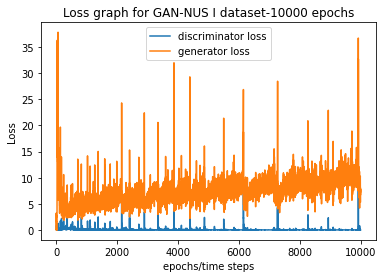

In [ ]:
import matplotlib.pyplot as plt
plt.plot(disc_loss,label='discriminator loss')
plt.plot(gen_loss,label='generator loss')
plt.xlabel('epochs/time steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss graph for GAN-NUS I dataset-10000 epochs')
plt.show()

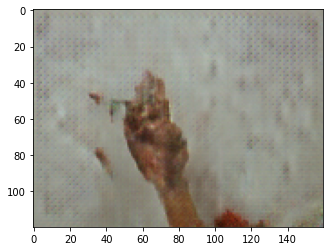

In [ ]:
#generating a random image
from numpy.random import randn
gm=load_model('drive/MyDrive/generator_model_test.h5')
vector=randn(100)
vector=vector.reshape(1,100)
image=gm.predict(vector)
image=0.5*image+0.5
plt.imshow(image[0,:,:,:])